In [1]:
import numpy as np
from grakel.datasets import fetch_dataset
from grakel.kernels import WeisfeilerLehman, VertexHistogram, EdgeHistogram, PyramidMatch
from grakel.kernels import SubgraphMatching, GraphletSampling, ShortestPath, RandomWalk, NeighborhoodHash
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def check_tria_ineq(K_candidate):
    D = 0.5* (np.diag(K_candidate).reshape(-1,1) @ np.ones((K_candidate.shape[0], 1)).T + np.ones((K_candidate.shape[0], 1)) @ np.diag(K_candidate).reshape(1,-1)) - K_candidate
    # sns.heatmap(D)
    # plt.title(f'Distance')
    # plt.show()
    tria_ineq = True
    for x in range(len(D)):
        if not tria_ineq: break
        for y in range(x+1, len(D)):
            if not tria_ineq: break
            for z in range(y+1, len(D)):
                if not tria_ineq: break
                diff1 = D[x,y] + D[x,z] - D[y,z]
                diff2 = D[x,z] + D[y,z] - D[x,y]
                diff3 = D[y,z] + D[x,y] - D[x,z]
                if (diff1 < 0 ) or (diff2 < 0 ) or (diff3 < 0):
                    print(f'Invalid Triangle Inequality (Triplet: No.{x+1,y+1,z+1})')
                    print(f'D[{x},{y}] + D[{x},{z}] - D[{y},{z}] {diff1}')
                    print(f'D[{x},{z}] + D[{y},{z}] - D[{x},{y}] {diff2}')
                    print(f'D[{y},{z}] + D[{x},{y}] - D[{x},{z}] {diff3}')
                    tria_ineq = False

    return tria_ineq

def check_psd(K):
    eigenValues = np.linalg.eigvals(K) #scipy.linalg.eigh(K_new, eigvals_only=True) 
    psd = 'True'
    print("K's min eigenvalue:",min(eigenValues))
    if (0 - min(eigenValues)) > 1e-08: 
        psd = f'False\nmin eig:\n{min(eigenValues)}\nneg eig num:{len(np.argwhere(eigenValues<0))}'
        plt.figure(figsize=(3,2))
        sns.heatmap(K)
        plt.title(f'psd: {psd}')
        plt.show()
        psd = 'True'
        K = K - float(min(eigenValues)) * np.eye(K.shape[0])
        eigenValues = np.linalg.eigvals(K) 
        print("K_new's min eigenvalue:",min(eigenValues))
        if (0 - min(eigenValues)) > 1e-08: 
            psd = f'False\nmin eig:\n{min(eigenValues)}\nneg eig num:{len(np.argwhere(eigenValues<0))}'    
    plt.figure(figsize=(3,2))
    sns.heatmap(K)
    plt.title(f'psd: {psd}')
    plt.show()

In [3]:
dataname = 'MSRC_9'

print(f'Fetching {dataname} dataset...')
data = fetch_dataset(dataname.upper(), verbose=False, prefer_attr_nodes=False)
print(f'Finish fetching!')
G, y = data.data, data.target

Fetching MSRC_9 dataset...
Finish fetching!


In [4]:
G_adj = np.row_stack([np.array(G)[np.where(y == num)[0].astype(np.uint64)] for num in np.unique(y)])
y_adj = np.concatenate([y[np.argwhere(y == num).ravel()] for num in np.unique(y)])

In [5]:
[len(np.where(y_adj == num)[0]) for num in np.unique(y)], len(G_adj)

([19, 30, 30, 30, 23, 30, 29, 30], 221)

In [6]:
K_dict = dict()

# Get Kernels

In [7]:
def get_VH(G):
    wl_kernel = VertexHistogram(normalize=True, sparse='auto')
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'VH')
    plt.show()
    return K

def get_PM(G, L_value, d_value):
    wl_kernel = PyramidMatch(normalize=True, L = L_value, d = d_value)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'PM')
    plt.show()
    return K

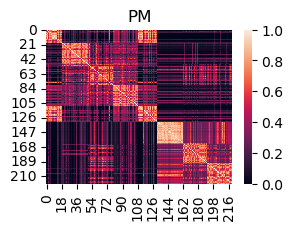

In [8]:
K_dict['K_PM_4_6'] = get_PM(G_adj, 4, 6)

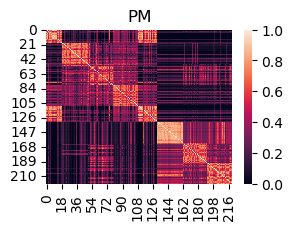

In [9]:
K_dict['K_PM_5_6'] = get_PM(G_adj, 5, 6)

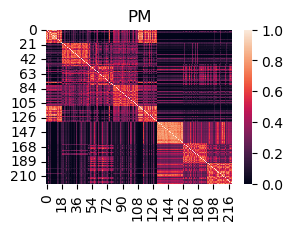

In [10]:
K_dict['K_PM_6_6'] = get_PM(G_adj, 6, 6)

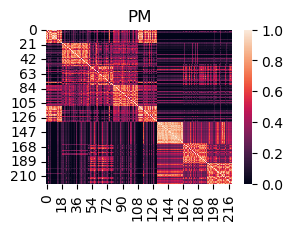

In [11]:
K_dict['K_PM_4_7'] = get_PM(G_adj, 4, 7)

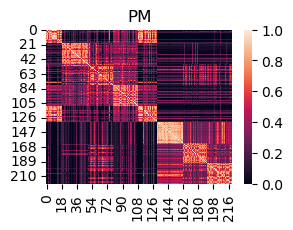

In [12]:
K_dict['K_PM_4_8'] = get_PM(G_adj, 4, 8)

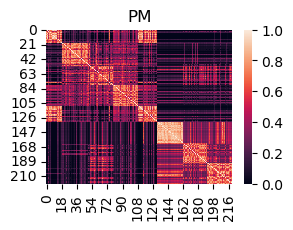

In [13]:
K_dict['K_PM_4_9'] = get_PM(G_adj, 4, 9)

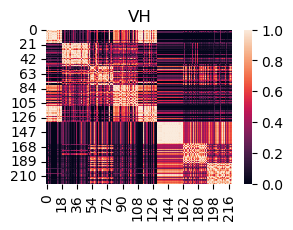

In [14]:
K_dict['K_VH'] = get_VH(G_adj)

In [15]:
def get_NH(G, R_value = 3, bits_value = 8):
    wl_kernel = NeighborhoodHash(normalize=True, R = R_value, bits = bits_value)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'NH-{R_value}-{bits_value}')
    plt.show()
    return K

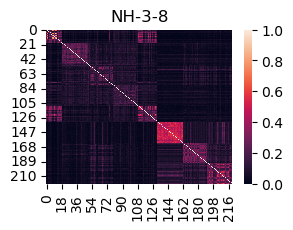

In [16]:
K_dict['K_NH_3_8'] = get_NH(G_adj, 3, 8)

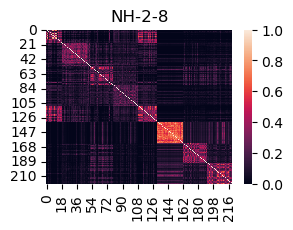

In [51]:
K_dict['K_NH_2_8'] = get_NH(G_adj, 2, 8)

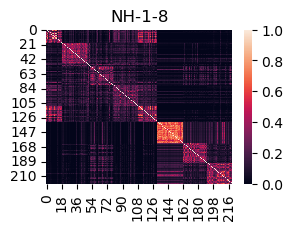

In [18]:
K_dict['K_NH_1_8'] = get_NH(G_adj, 1, 8)

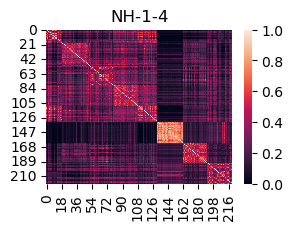

In [19]:
K_dict['K_NH_1_4'] = get_NH(G_adj, 1, 4)

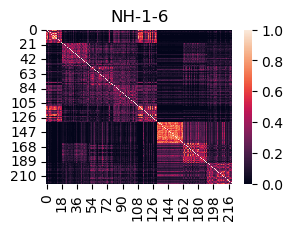

In [20]:
K_dict['K_NH_1_6'] = get_NH(G_adj, 1, 6)

## WL [WeisfeilerLehman]

In [15]:
def get_WL(G, iter_num = 1):
    wl_kernel = WeisfeilerLehman(n_iter=iter_num, normalize=True, base_graph_kernel=VertexHistogram)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'WL-{iter_num}')
    plt.show()
    return K

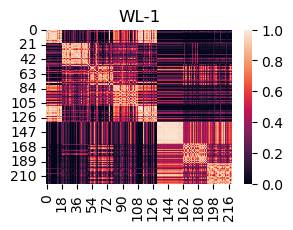

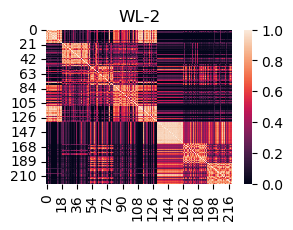

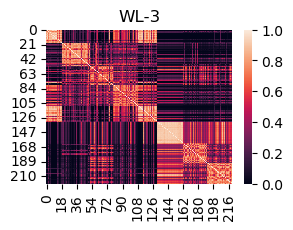

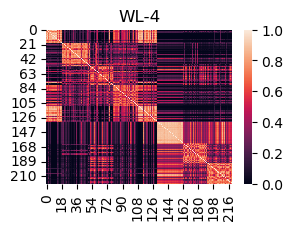

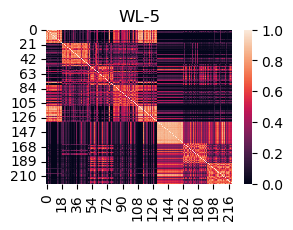

In [16]:
for h in range(1, 6):
    name = f'K_WL_{h}'
    K_dict[name] = get_WL(G_adj, h)

## GS [GraphletSampling]

In [17]:
def get_GS(G, k_num = 4):
    wl_kernel = GraphletSampling(normalize=True, k=k_num)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'GS-{k_num} train')
    plt.show()

    return K

In [18]:
# for k in range(4, 10):
#     name = f'K_GS_{k}'
#     K_dict[name] = get_GS(G_adj, k)

## SP [ShortestPath]

In [19]:
def get_SP(G, algo):
    wl_kernel = ShortestPath(normalize=True, algorithm_type=algo)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'SP {algo}')
    plt.show()
    
    return K

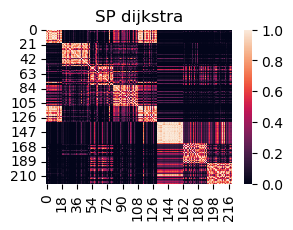

In [20]:
name = 'K_SP'
K_dict[name] = get_SP(G_adj, "dijkstra")

## RW [RandomWalk]

In [21]:
def get_RW(G, lambda_value = 0.1):
    wl_kernel = RandomWalk(lamda=lambda_value, normalize=True, kernel_type="exponential")
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'RW-{lambda_value}')
    plt.show()

    return K

In [28]:
# for lam in range(5, 6, 5):
#     lam /= 10.
#     name = f'K_RW_{lam}'
#     K_dict[name] = get_RW(G_adj, lam)

# Algorithm

In [27]:
import scipy
from scipy.sparse import csgraph
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import pandas as pd

In [28]:
def cal_acc(y_true, y_pred):
    """
    Calculate clustering accuracy.
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from scipy.optimize import linear_sum_assignment as linear_assignment
    ind_row, ind_col = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(ind_row, ind_col)]) * 1.0 / y_pred.size


def cal_Lap_eigen(K, class_num):
    L = csgraph.laplacian(K, normed=True)
    eigenValues, eigenVectors = scipy.linalg.eigh(L, subset_by_index=[class_num-1, class_num])
    return (eigenValues, eigenVectors[0], eigenVectors[1])

def gk_L(K, coef = 1):

    n = K.shape[0]
    D = np.sum(K, axis = 0)

    D15 = np.diag(np.power(D, -1.5))
    D05 = np.diag(np.power(D, -0.5))
    D1 = np.diag(np.power(D, -1))

    U0 = - 0.5 * D15 @ K @ D05 * coef
    U1 = - 0.5 * D05 @ K @ D15 * coef

    U0 = np.tile(U0.sum(axis = 1), (n, 1))
    U1 = np.transpose(np.tile(U1.sum(axis = 0), (n, 1)))
    grad_K = - (U0 + U1 + D1 * coef)
    
    return grad_K

def gw_K(K_list):
    return np.array(K_list)

def get_Knew(prev_w, K_list):
    T = len(prev_w)
    p, q = K_list[0].shape

    K_new = np.zeros((p, q))
    for t in range(T):
        K_new += prev_w[t] * K_list[t]
    return K_new

def cal_grad_w(prev_w, K_list, K_new, class_num, return_grad_A = False):

    T = len(prev_w)
    eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_new, class_num)
    eigen_k = eigenValues[0]
    eigen_gap = np.diff(eigenValues)
    eigen_gap_ratio = eigen_gap/eigen_k
    eigenV_kp1_trace = np.transpose(eigenV_kp1 @ eigenV_kp1)
    eigenV_trace = np.transpose(eigenV @ eigenV)
    inv_trace1 = np.power(eigen_gap, -1) * (eigenV_kp1_trace - eigenV_trace)
    inv_trace2 = np.power(eigen_k,-1) * (eigenV_trace)

    grad_LK = gk_L(K_new, (inv_trace1 - inv_trace2))
    grad_Lw = gw_K(K_list)
    grad = np.sum(np.sum(grad_Lw * grad_LK, axis = 1), axis = 1)

    if return_grad_A:
        grad_A = grad_LK
        return grad.flatten(), grad_A, eigen_gap_ratio
        
    return grad.flatten(), eigen_gap_ratio


In [29]:
def project_simplex(x):
    """ Take a vector x (with possible nonnegative entries and non-normalized)
        and project it onato the unit simplex.
    """
    xsorted = np.sort(x)[::-1]
    # remaining entries need to sum up to 1
    sum_ = 1.0

    lambda_a = (np.cumsum(xsorted) - sum_) / np.arange(1.0, len(xsorted)+1.0)
    for i in range(len(lambda_a)-1):
        if lambda_a[i] >= xsorted[i+1]:
            astar = i
            break
    else:
        astar = -1

    p = np.maximum(x-lambda_a[astar],  0)
    return p

In [30]:
def train_A(K_list, init_type, class_num = 2, stepsize = 1e-4, stepsize_2 = 1e-6, num_iter = 200):
    T = len(K_list)

    score_dict = {'Accuracy': [], "Normalized_Mutual_Info": []}
    weights_list = []
    gap_list = []

    # initialize weights
    if init_type == 'uniform':
        weights = np.ones(T)/T
        
    elif init_type == 'eigen':
        eigen_weights_list = []
        for K_train in K_list:
            eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, class_num)
            eigen_gap = np.diff(eigenValues)
            eigen_weights_list.append(eigen_gap)
        eigen_weights = np.array(eigen_weights_list)
        eigen_weights /= np.sum(eigen_weights)
        weights = eigen_weights.ravel()

    elif init_type == 'eigen_inv':
        eigen_weights_list = []
        for K_train in K_list:
            eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, class_num)
            eigen_gap = np.diff(eigenValues)
            eigen_weights_list.append(eigen_gap)
        eigen_weights = np.sum(np.array(eigen_weights_list)) - np.array(eigen_weights_list)
        eigen_weights /= np.sum(eigen_weights)
        weights = eigen_weights.ravel()

    elif init_type == 'random':
        weights = np.random.dirichlet(np.ones(T))

    else:
        weights = init_type

    K_best = np.zeros(K_list[0].shape)
    score_best = 0
    A = np.zeros(K_list[0].shape)#np.random.random(K_list[0].shape) * 1e-4
    # num_iter_mom = 50
    # update_w = np.zeros(n)
    for i in range(num_iter):
        # if i < num_iter_mom:
        #     momentum = 0.8
        # else:
        #     momentum = 0.2
        K_new = np.nan_to_num(get_Knew(weights, K_list) + A)
        grad, grad_A, obj = cal_grad_w(weights, K_list, K_new, class_num, return_grad_A=True)
        A += (stepsize_2 * grad_A)

        # update_w = (momentum * update_w) + (stepsize * grad)
        # weights += update_w
        weights += (stepsize * grad)
        weights = project_simplex(weights)

        weights_list.append(weights)
        gap_list.append(obj)
        y_pred = SpectralClustering(n_clusters = class_num, 
                                    random_state = 0,
                                    affinity = 'precomputed').fit_predict(K_new)

        acc_score = cal_acc(y_adj, y_pred)
        nmi = metrics.normalized_mutual_info_score(y_adj, y_pred)
        score_dict['Accuracy'].append(acc_score)
        score_dict['Normalized_Mutual_Info'].append(nmi)

        if score_best < acc_score: K_best = K_new

        if (i%10 == 0): 
            weight_norm = np.linalg.norm(weights)
            weight_sum = np.sum(weights)
            print(f'----- At No.{i+1} iteration: sum: {np.round(weight_sum, 4)} norm: {np.round(weight_norm, 4)}-----')
            print(f"eigengap ratio: {obj}")
            print(f"acc_score: {acc_score}; nmi: {nmi}\n")


    plt.plot(range(num_iter), gap_list)
    plt.title(f'Eigengap Ratio')
    plt.xlabel = 'Num of Iterations'
    plt.show()

    return K_new, K_best, A, weights, score_dict

----- At No.1 iteration: sum: 1.0 norm: 0.2778-----
eigengap ratio: [0.0259946]
acc_score: 0.8144796380090498; nmi: 0.7782019576115897

----- At No.11 iteration: sum: 1.0 norm: 0.3227-----
eigengap ratio: [0.02800232]
acc_score: 0.8461538461538461; nmi: 0.8063728948155854

----- At No.21 iteration: sum: 1.0 norm: 0.3848-----
eigengap ratio: [0.02875122]
acc_score: 0.8506787330316742; nmi: 0.8110239888402896

----- At No.31 iteration: sum: 1.0 norm: 0.4532-----
eigengap ratio: [0.02899382]
acc_score: 0.8552036199095022; nmi: 0.8135718421671292

----- At No.41 iteration: sum: 1.0 norm: 0.5287-----
eigengap ratio: [0.02908335]
acc_score: 0.8461538461538461; nmi: 0.8080128757389836

----- At No.51 iteration: sum: 1.0 norm: 0.6115-----
eigengap ratio: [0.02925438]
acc_score: 0.8461538461538461; nmi: 0.8092554138723979

----- At No.61 iteration: sum: 1.0 norm: 0.6903-----
eigengap ratio: [0.02942126]
acc_score: 0.8461538461538461; nmi: 0.809255413872398

----- At No.71 iteration: sum: 1.0 no

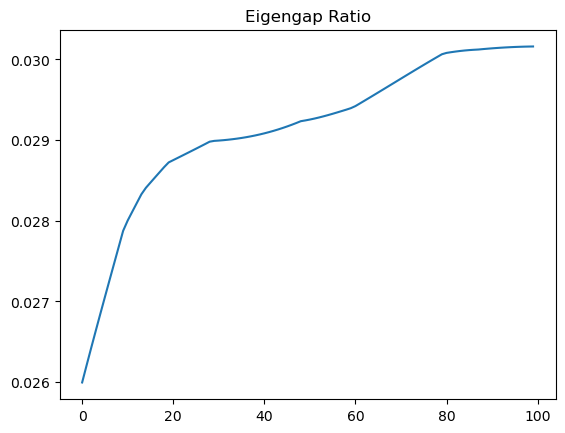

===== Individual acc_score | nmi=====
K_PM_4_6: 0.8643(acc); 0.8317(nmi) | weight: 0.0000
K_PM_5_6: 0.8643(acc); 0.8317(nmi) | weight: 0.0000
K_PM_6_6: 0.8643(acc); 0.8317(nmi) | weight: 0.1531
K_PM_4_7: 0.8643(acc); 0.8317(nmi) | weight: 0.0000
K_PM_4_8: 0.8643(acc); 0.8317(nmi) | weight: 0.0000
K_PM_4_9: 0.8643(acc); 0.8317(nmi) | weight: 0.0000
K_VH: 0.7511(acc); 0.7034(nmi) | weight: 0.0000
K_WL_1: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_2: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_3: 0.7602(acc); 0.7132(nmi) | weight: 0.0000
K_WL_4: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_5: 0.7647(acc); 0.7116(nmi) | weight: 0.0000
K_SP: 0.7647(acc); 0.7328(nmi) | weight: 0.8469
===== Joint kernel =====


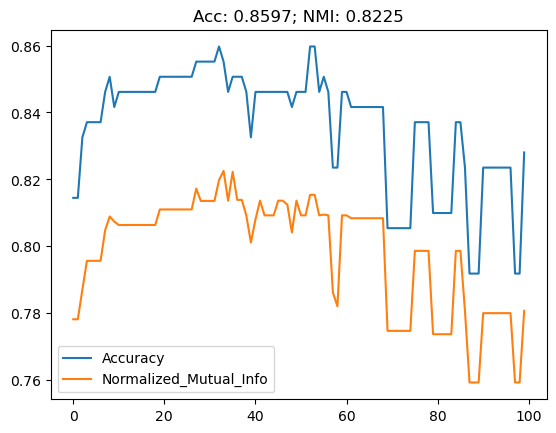

In [38]:
K_list = list(K_dict.values())
num_iter = 100
class_num = len(np.unique(y))
K_new, K_best, A_new, weights, score_dict = train_A(K_list, 'uniform', class_num, 1e-4, 1e-4, num_iter)
display_results(list(K_dict.keys()), K_list, weights, score_dict, num_iter, class_num)

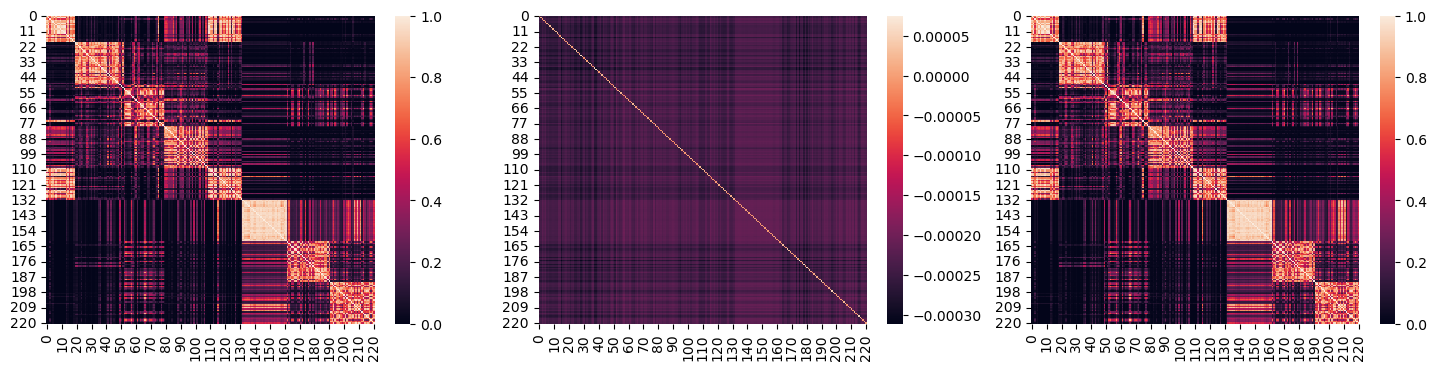

In [39]:
plt.figure(figsize=(18, 4))
plt.subplot(131)
sns.heatmap(get_Knew(weights, K_list))
plt.subplot(132)
sns.heatmap(A_new)
plt.subplot(133)
sns.heatmap(K_new)
plt.show()

----- At No.1 iteration: sum: 1.0 norm: 0.2778-----
eigengap ratio: [0.0259946]
acc_score: 0.8144796380090498; nmi: 0.7782019576115897

----- At No.11 iteration: sum: 1.0 norm: 0.3227-----
eigengap ratio: [0.02799877]
acc_score: 0.8461538461538461; nmi: 0.8063728948155854

----- At No.21 iteration: sum: 1.0 norm: 0.3848-----
eigengap ratio: [0.02874333]
acc_score: 0.8506787330316742; nmi: 0.8110239888402896

----- At No.31 iteration: sum: 1.0 norm: 0.4532-----
eigengap ratio: [0.0289812]
acc_score: 0.8552036199095022; nmi: 0.8135718421671292

----- At No.41 iteration: sum: 1.0 norm: 0.5288-----
eigengap ratio: [0.02906588]
acc_score: 0.8461538461538461; nmi: 0.8080128757389836

----- At No.51 iteration: sum: 1.0 norm: 0.6116-----
eigengap ratio: [0.02923185]
acc_score: 0.8461538461538461; nmi: 0.8092554138723979

----- At No.61 iteration: sum: 1.0 norm: 0.6904-----
eigengap ratio: [0.02939403]
acc_score: 0.8461538461538461; nmi: 0.809255413872398

----- At No.71 iteration: sum: 1.0 nor

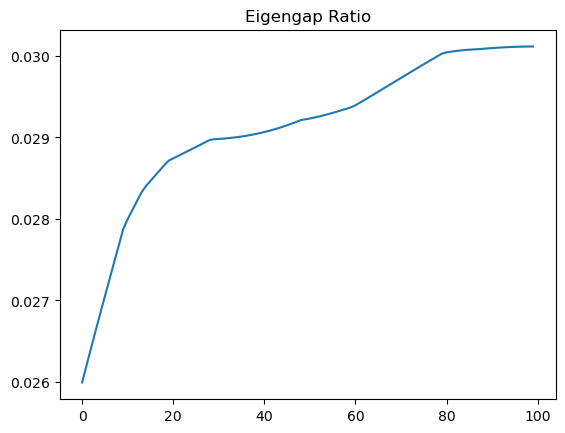

===== Individual acc_score | nmi=====
K_PM_4_6: 0.8643(acc); 0.8317(nmi) | weight: 0.0000
K_PM_5_6: 0.8643(acc); 0.8317(nmi) | weight: 0.0000
K_PM_6_6: 0.8643(acc); 0.8317(nmi) | weight: 0.1531
K_PM_4_7: 0.8643(acc); 0.8317(nmi) | weight: 0.0000
K_PM_4_8: 0.8643(acc); 0.8317(nmi) | weight: 0.0000
K_PM_4_9: 0.8643(acc); 0.8317(nmi) | weight: 0.0000
K_VH: 0.7511(acc); 0.7034(nmi) | weight: 0.0000
K_WL_1: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_2: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_3: 0.7602(acc); 0.7132(nmi) | weight: 0.0000
K_WL_4: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_5: 0.7647(acc); 0.7116(nmi) | weight: 0.0000
K_SP: 0.7647(acc); 0.7328(nmi) | weight: 0.8469
===== Joint kernel =====


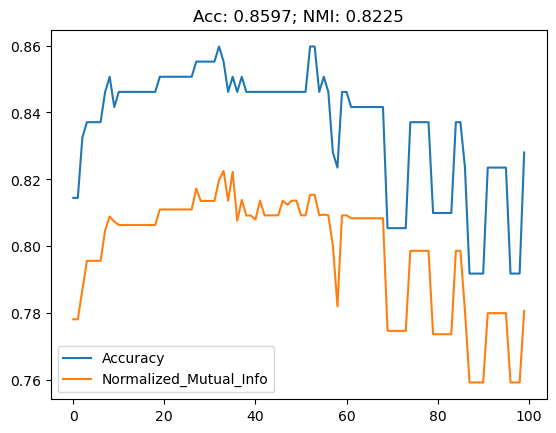

In [49]:
K_list = list(K_dict.values())
num_iter = 100
class_num = len(np.unique(y))
K_new, weights, score_dict = train(K_list, 'uniform', class_num, 1e-4, num_iter)
display_results(list(K_dict.keys()), K_list, weights, score_dict, num_iter, class_num)

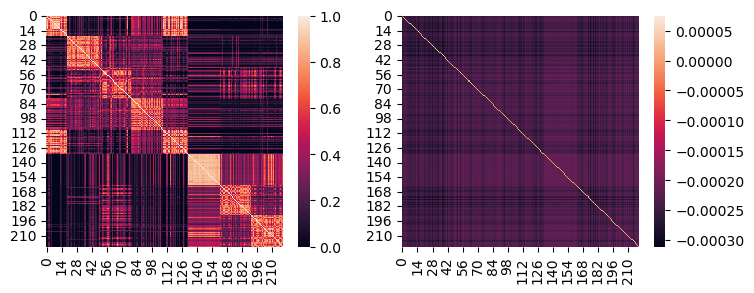

In [48]:
plt.figure(figsize=(13, 3))
plt.subplot(131)
sns.heatmap(K_new)
plt.subplot(132)
sns.heatmap(A_new)
plt.show()

In [30]:
len(K_dict.values())

6

In [32]:
def train(K_list, init_type, class_num = 2, stepsize = 1e-4, num_iter = 200):
    n = len(K_list)

    score_dict = {'Accuracy': [], "Normalized_Mutual_Info": []}
    weights_list = []
    gap_list = []

    # initialize weights
    if init_type == 'uniform':
        weights = np.ones(n)/n
        
    elif init_type == 'eigen':
        eigen_weights_list = []
        for K_train in K_list:
            eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, class_num)
            eigen_gap = np.diff(eigenValues)
            eigen_weights_list.append(eigen_gap)
        eigen_weights = np.array(eigen_weights_list)
        eigen_weights /= np.sum(eigen_weights)
        weights = eigen_weights.ravel()

    elif init_type == 'eigen_inv':
        eigen_weights_list = []
        for K_train in K_list:
            eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, class_num)
            eigen_gap = np.diff(eigenValues)
            eigen_weights_list.append(eigen_gap)
        eigen_weights = np.sum(np.array(eigen_weights_list)) - np.array(eigen_weights_list)
        eigen_weights /= np.sum(eigen_weights)
        weights = eigen_weights.ravel()

    elif init_type == 'random':
        weights = np.random.dirichlet(np.ones(n))

    else:
        weights = init_type


    # num_iter_mom = 50
    # update_w = np.zeros(n)
    for i in range(num_iter):
        # if i < num_iter_mom:
        #     momentum = 0.8
        # else:
        #     momentum = 0.2
        K_new = np.nan_to_num(get_Knew(weights, K_list))
        grad, obj = cal_grad_w(weights, K_list, K_new, class_num)

        # update_w = (momentum * update_w) + (stepsize * grad)
        # weights += update_w
        weights += (stepsize * grad)
        weights = project_simplex(weights)

        weights_list.append(weights)
        gap_list.append(obj)
        y_pred = SpectralClustering(n_clusters = class_num, 
                                    random_state = 0,
                                    affinity = 'precomputed').fit_predict(K_new)

        acc_score = cal_acc(y_adj, y_pred)
        nmi = metrics.normalized_mutual_info_score(y_adj, y_pred)
        score_dict['Accuracy'].append(acc_score)
        score_dict['Normalized_Mutual_Info'].append(nmi)

        if (i%10 == 0): 
            weight_norm = np.linalg.norm(weights)
            weight_sum = np.sum(weights)
            print(f'----- At No.{i+1} iteration: sum: {np.round(weight_sum, 4)} norm: {np.round(weight_norm, 4)}-----')
            print(f"eigengap ratio: {obj}")
            print(f"acc_score: {acc_score}; nmi: {nmi}\n")


    plt.plot(range(num_iter), gap_list)
    plt.title(f'Eigengap Ratio')
    plt.xlabel = 'Num of Iterations'
    plt.show()

    return K_new, weights, score_dict

In [33]:
def display_results(kernel_name, K_list, weights, score_dict, num_iter, class_num):
    print('===== Individual acc_score | nmi=====')
    i = 0
    for K_candidate in K_list:
        y_pred = SpectralClustering(n_clusters = class_num, 
                                    random_state = 0,
                                    affinity = 'precomputed').fit_predict(K_candidate)

        acc_score = cal_acc(y_adj, y_pred)
        nmi = metrics.normalized_mutual_info_score(y_adj, y_pred)
        print("%s: %.4f(acc); %.4f(nmi) | weight: %.4f"%(kernel_name[i], acc_score, nmi, weights[i]))
        i += 1

    print('===== Joint kernel =====')
    plt.plot(range(num_iter), pd.DataFrame(score_dict))
    plt.title('Acc: %.4f; NMI: %.4f'%(max(score_dict["Accuracy"]), max(score_dict["Normalized_Mutual_Info"])))
    plt.legend(list(score_dict.keys()))
    plt.xlabel = 'Num of Iterations'
    plt.show()

# All kernels

In [35]:
eigen_weights_list = []
K_list = list(K_dict.values())
for K_train in K_list:
    eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, len(np.unique(y)))
    eigen_gap = np.diff(eigenValues)
    eigen_weights_list.append(eigen_gap)
print(dict(zip(list(K_dict.keys()), eigen_weights_list)))

{'K_PM_4_6': array([0.03144494]), 'K_PM_5_6': array([0.03070857]), 'K_PM_6_6': array([0.0293462]), 'K_PM_4_7': array([0.03153199]), 'K_PM_4_8': array([0.03143676]), 'K_PM_4_9': array([0.03145091]), 'K_VH': array([0.01900029]), 'K_WL_1': array([0.02171979]), 'K_WL_2': array([0.02184736]), 'K_WL_3': array([0.02194325]), 'K_WL_4': array([0.02202886]), 'K_WL_5': array([0.02210586]), 'K_SP': array([0.02584237])}


## Uniform init

----- At No.1 iteration: sum: 1.0 norm: 0.4083-----
eigengap ratio: [0.02537855]
acc_score: 0.7692307692307693; nmi: 0.721198316589093

----- At No.11 iteration: sum: 1.0 norm: 0.4204-----
eigengap ratio: [0.02627537]
acc_score: 0.7737556561085973; nmi: 0.7310387455740188

----- At No.21 iteration: sum: 1.0 norm: 0.4511-----
eigengap ratio: [0.02694939]
acc_score: 0.7828054298642534; nmi: 0.7428581389429072

----- At No.31 iteration: sum: 1.0 norm: 0.4978-----
eigengap ratio: [0.02743382]
acc_score: 0.7828054298642534; nmi: 0.7428581389429072

----- At No.41 iteration: sum: 1.0 norm: 0.5558-----
eigengap ratio: [0.02777955]
acc_score: 0.7963800904977375; nmi: 0.7508390026802034

----- At No.51 iteration: sum: 1.0 norm: 0.6092-----
eigengap ratio: [0.02801753]
acc_score: 0.8009049773755657; nmi: 0.7513033989247823

----- At No.61 iteration: sum: 1.0 norm: 0.6621-----
eigengap ratio: [0.02822084]
acc_score: 0.7873303167420814; nmi: 0.7484154869186732

----- At No.71 iteration: sum: 1.0 n

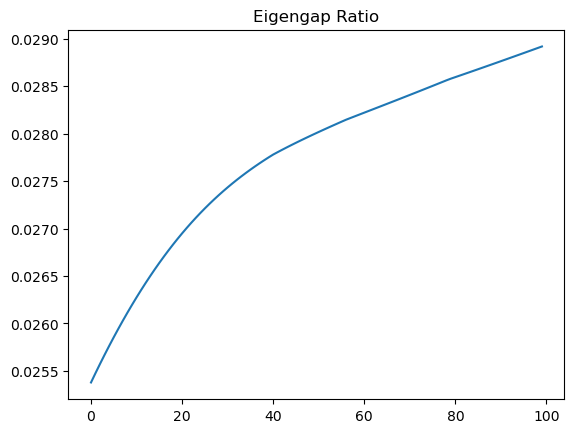

Final weights: [0.         0.         0.         0.02847893 0.13747769 0.83404338]
===== Individual acc_score | nmi=====
K_WL_1: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_2: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_3: 0.7602(acc); 0.7132(nmi) | weight: 0.0000
K_WL_4: 0.7602(acc); 0.7182(nmi) | weight: 0.0285
K_WL_5: 0.7647(acc); 0.7116(nmi) | weight: 0.1375
K_SP: 0.7647(acc); 0.7328(nmi) | weight: 0.8340
===== Joint kernel =====


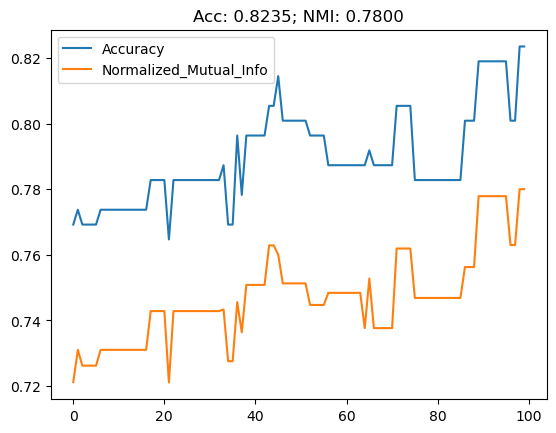

In [41]:
K_list = list(K_dict.values())
num_iter = 100
class_num = len(np.unique(y))
K_new, weights, score_dict = train(K_list, 'uniform', class_num, 1e-4, num_iter)
print("Final weights:", weights)
display_results(list(K_dict.keys()), K_list, weights, score_dict, num_iter, class_num)

K's min eigenvalue: 0.011524944531071233


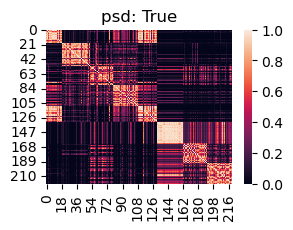

In [43]:
# for K_train in K_list:
#     check_psd(K_train)
check_psd(K_new)

## Eigen init

----- At No.1 iteration: sum: 1.0 norm: 0.4098-----
eigengap ratio: [0.02568587]
acc_score: 0.7692307692307693; nmi: 0.7262225797908851

----- At No.11 iteration: sum: 1.0 norm: 0.427-----
eigengap ratio: [0.02650873]
acc_score: 0.7737556561085973; nmi: 0.7310387455740188

----- At No.21 iteration: sum: 1.0 norm: 0.4623-----
eigengap ratio: [0.02711816]
acc_score: 0.7828054298642534; nmi: 0.7428581389429074

----- At No.31 iteration: sum: 1.0 norm: 0.5127-----
eigengap ratio: [0.02755365]
acc_score: 0.7873303167420814; nmi: 0.7433234543933628

----- At No.41 iteration: sum: 1.0 norm: 0.5712-----
eigengap ratio: [0.02786376]
acc_score: 0.8054298642533937; nmi: 0.7628895581765089

----- At No.51 iteration: sum: 1.0 norm: 0.6269-----
eigengap ratio: [0.02809066]
acc_score: 0.7963800904977375; nmi: 0.7447249267014123

----- At No.61 iteration: sum: 1.0 norm: 0.6788-----
eigengap ratio: [0.02828701]
acc_score: 0.7963800904977375; nmi: 0.754733282838564

----- At No.71 iteration: sum: 1.0 no

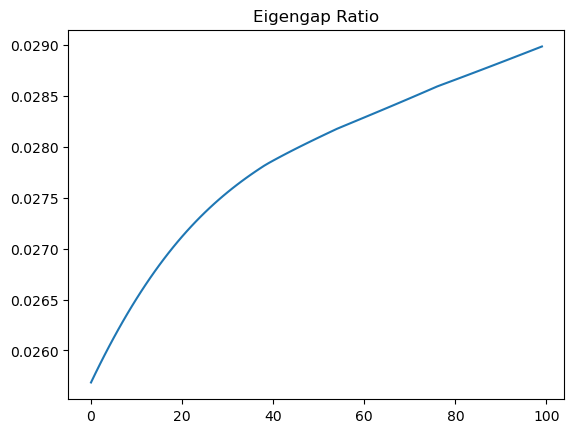

Final weights: [0.         0.         0.         0.01880398 0.12838851 0.85280751]
===== Individual acc_score | nmi=====
K_WL_1: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_2: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_3: 0.7602(acc); 0.7132(nmi) | weight: 0.0000
K_WL_4: 0.7602(acc); 0.7182(nmi) | weight: 0.0188
K_WL_5: 0.7647(acc); 0.7116(nmi) | weight: 0.1284
K_SP: 0.7647(acc); 0.7328(nmi) | weight: 0.8528
===== Joint kernel =====


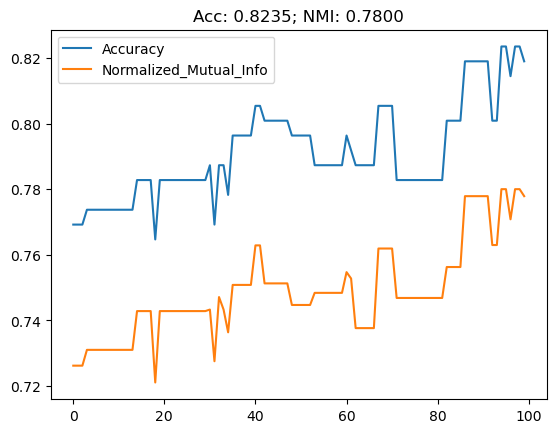

In [44]:
K_list = list(K_dict.values())
num_iter = 100
class_num = len(np.unique(y))
K_new, weights, score_dict = train(K_list, 'eigen', class_num, 1e-4, num_iter)
print("Final weights:", weights)
display_results(list(K_dict.keys()), K_list, weights, score_dict, num_iter, class_num)

----- At No.1 iteration: sum: 1.0 norm: 0.4083-----
eigengap ratio: [0.02531426]
acc_score: 0.7692307692307693; nmi: 0.721198316589093

----- At No.11 iteration: sum: 1.0 norm: 0.4192-----
eigengap ratio: [0.02622607]
acc_score: 0.7737556561085973; nmi: 0.7310387455740188

----- At No.21 iteration: sum: 1.0 norm: 0.449-----
eigengap ratio: [0.0269135]
acc_score: 0.7828054298642534; nmi: 0.7428581389429072

----- At No.31 iteration: sum: 1.0 norm: 0.4949-----
eigengap ratio: [0.02740839]
acc_score: 0.7828054298642534; nmi: 0.7428581389429072

----- At No.41 iteration: sum: 1.0 norm: 0.5528-----
eigengap ratio: [0.02776117]
acc_score: 0.7963800904977375; nmi: 0.7508390026802034

----- At No.51 iteration: sum: 1.0 norm: 0.6057-----
eigengap ratio: [0.02800267]
acc_score: 0.8009049773755657; nmi: 0.7513033989247823

----- At No.61 iteration: sum: 1.0 norm: 0.6588-----
eigengap ratio: [0.02820765]
acc_score: 0.7873303167420814; nmi: 0.7484154869186732

----- At No.71 iteration: sum: 1.0 nor

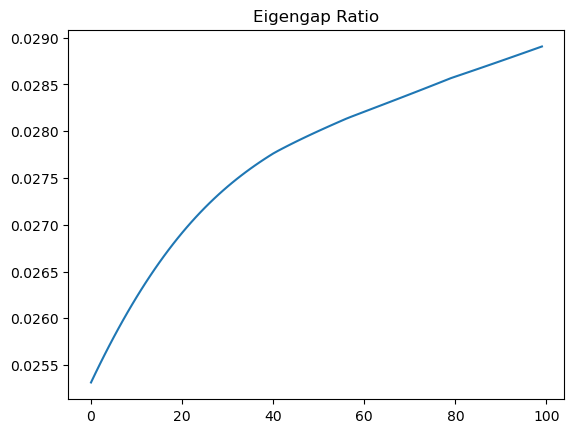

Final weights: [0.         0.         0.         0.03041734 0.13929768 0.83028498]
===== Individual acc_score | nmi=====
K_WL_1: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_2: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_3: 0.7602(acc); 0.7132(nmi) | weight: 0.0000
K_WL_4: 0.7602(acc); 0.7182(nmi) | weight: 0.0304
K_WL_5: 0.7647(acc); 0.7116(nmi) | weight: 0.1393
K_SP: 0.7647(acc); 0.7328(nmi) | weight: 0.8303
===== Joint kernel =====


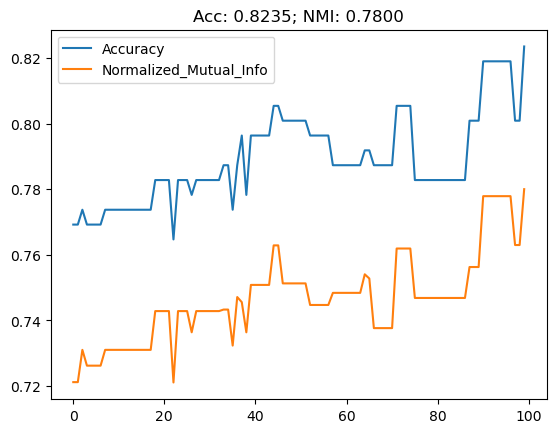

In [45]:
K_list = list(K_dict.values())
num_iter = 100
class_num = len(np.unique(y))
K_new, weights, score_dict = train(K_list, 'eigen_inv', class_num, 1e-4, num_iter)
print("Final weights:", weights)
display_results(list(K_dict.keys()), K_list, weights, score_dict, num_iter, class_num)

## Random init

----- At No.1 iteration: sum: 1.0 norm: 0.4757-----
eigengap ratio: [0.023758]
acc_score: 0.7692307692307693; nmi: 0.726222579790885

----- At No.11 iteration: sum: 1.0 norm: 0.4526-----
eigengap ratio: [0.02493635]
acc_score: 0.7647058823529411; nmi: 0.7146380882463846

----- At No.21 iteration: sum: 1.0 norm: 0.4468-----
eigengap ratio: [0.02590308]
acc_score: 0.7737556561085973; nmi: 0.7310387455740188

----- At No.31 iteration: sum: 1.0 norm: 0.4589-----
eigengap ratio: [0.02665683]
acc_score: 0.7737556561085973; nmi: 0.7310387455740188

----- At No.41 iteration: sum: 1.0 norm: 0.4879-----
eigengap ratio: [0.02721819]
acc_score: 0.7828054298642534; nmi: 0.7428581389429074

----- At No.51 iteration: sum: 1.0 norm: 0.5319-----
eigengap ratio: [0.02762683]
acc_score: 0.7873303167420814; nmi: 0.743323454393363

----- At No.61 iteration: sum: 1.0 norm: 0.5884-----
eigengap ratio: [0.02793298]
acc_score: 0.8009049773755657; nmi: 0.7513033989247823

----- At No.71 iteration: sum: 1.0 norm

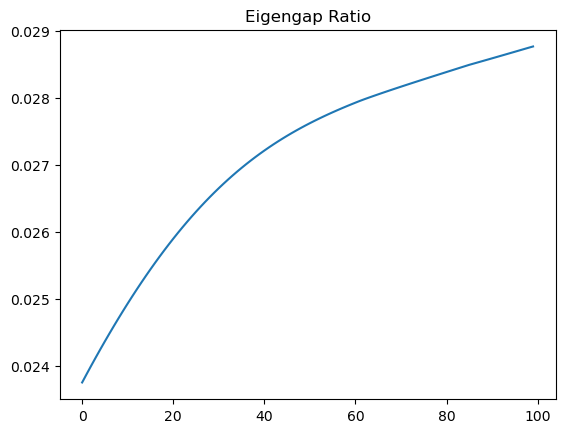

Final weights: [0.         0.         0.         0.         0.20788706 0.79211294]
===== Individual acc_score | nmi=====
K_WL_1: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_2: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_3: 0.7602(acc); 0.7132(nmi) | weight: 0.0000
K_WL_4: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_5: 0.7647(acc); 0.7116(nmi) | weight: 0.2079
K_SP: 0.7647(acc); 0.7328(nmi) | weight: 0.7921
===== Joint kernel =====


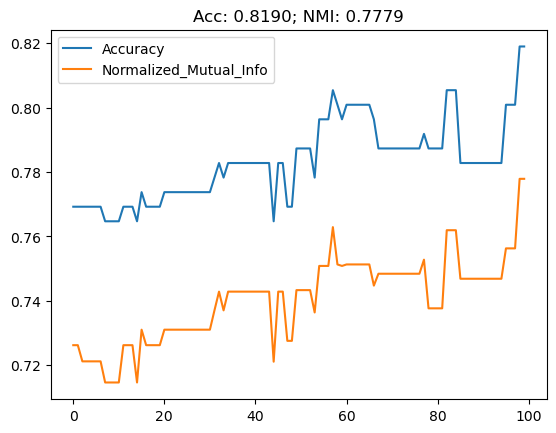

In [48]:
K_list = list(K_dict.values())
num_iter = 100
class_num = len(np.unique(y))
K_new, weights, score_dict = train(K_list, 'random', class_num, 1e-4, num_iter)
print("Final weights:", weights)
display_results(list(K_dict.keys()), K_list, weights, score_dict, num_iter, class_num)

# Kernels with the same type

## Uniform init

----- At No.1 iteration: sum: 1.0 norm: 0.7759-----
eigengap ratio: [0.02271752]
acc_score: 0.7601809954751131; nmi: 0.718210914252329

----- At No.11 iteration: sum: 1.0 norm: 0.9275-----
eigengap ratio: [0.02284922]
acc_score: 0.7647058823529411; nmi: 0.7116294273039254

----- At No.21 iteration: sum: 1.0 norm: 0.9836-----
eigengap ratio: [0.02285437]
acc_score: 0.7647058823529411; nmi: 0.7116294273039254

----- At No.31 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.02285635]
acc_score: 0.7647058823529411; nmi: 0.7116294273039254

----- At No.41 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.02285635]
acc_score: 0.7647058823529411; nmi: 0.7116294273039254

----- At No.51 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.02285635]
acc_score: 0.7647058823529411; nmi: 0.7116294273039254

----- At No.61 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.02285635]
acc_score: 0.7647058823529411; nmi: 0.7116294273039254

----- At No.71 iteration: sum: 1.0 norm: 1.0----

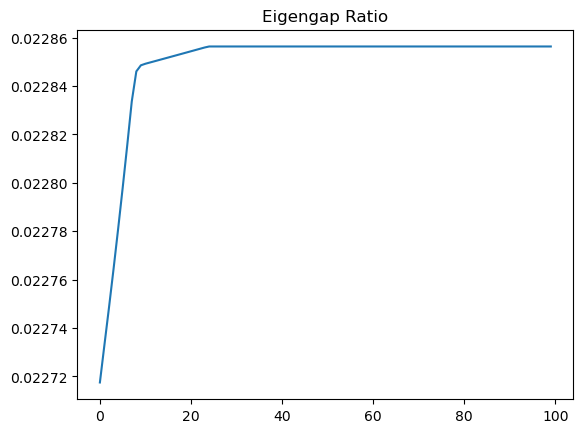

Final weights: [0. 0. 0. 0. 1.]
===== Individual acc_score | nmi=====
K_WL_1: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_2: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_3: 0.7602(acc); 0.7132(nmi) | weight: 0.0000
K_WL_4: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_5: 0.7647(acc); 0.7116(nmi) | weight: 1.0000
===== Joint kernel =====


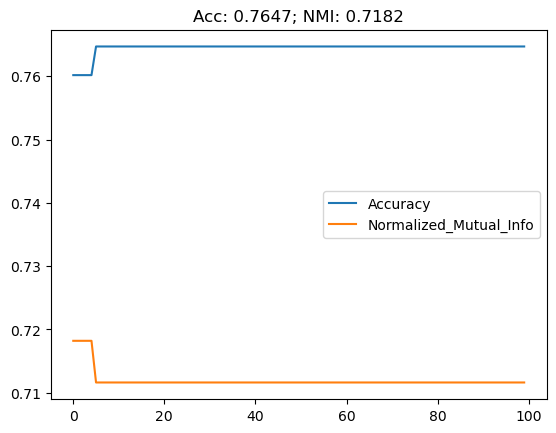

In [50]:
K_list = [K_dict[k] for k in K_dict.keys() if k.startswith("K_WL")]
kernel_name = [k for k in K_dict.keys() if k.startswith("K_WL")]
num_iter = 100

class_num = len(np.unique(y))
K_new, weights, score_dict = train(K_list, 'random', class_num, 1e-3, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter, class_num)

## Eigen init

----- At No.1 iteration: sum: 1.0 norm: 0.4493-----
eigengap ratio: [0.02265038]
acc_score: 0.7601809954751131; nmi: 0.7131804133720253

----- At No.11 iteration: sum: 1.0 norm: 0.5871-----
eigengap ratio: [0.02277494]
acc_score: 0.7601809954751131; nmi: 0.718210914252329

----- At No.21 iteration: sum: 1.0 norm: 0.6782-----
eigengap ratio: [0.02281009]
acc_score: 0.7647058823529411; nmi: 0.7116294273039254

----- At No.31 iteration: sum: 1.0 norm: 0.7504-----
eigengap ratio: [0.0228283]
acc_score: 0.7647058823529411; nmi: 0.7116294273039254

----- At No.41 iteration: sum: 1.0 norm: 0.782-----
eigengap ratio: [0.02283316]
acc_score: 0.7647058823529411; nmi: 0.7116294273039254

----- At No.51 iteration: sum: 1.0 norm: 0.8208-----
eigengap ratio: [0.0228381]
acc_score: 0.7647058823529411; nmi: 0.7116294273039254

----- At No.61 iteration: sum: 1.0 norm: 0.8659-----
eigengap ratio: [0.0228431]
acc_score: 0.7647058823529411; nmi: 0.7116294273039254

----- At No.71 iteration: sum: 1.0 norm:

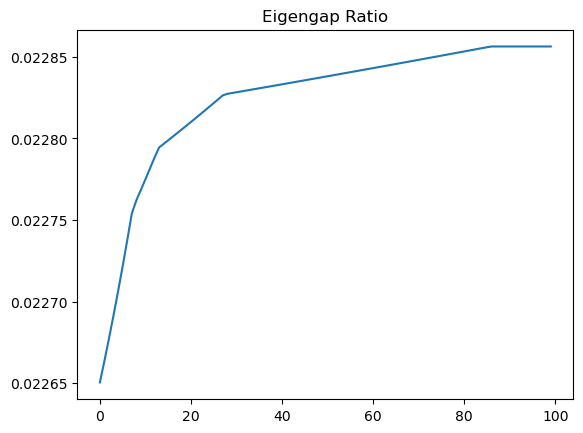

Final weights: [0. 0. 0. 0. 1.]
===== Individual acc_score | nmi=====
K_WL_1: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_2: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_3: 0.7602(acc); 0.7132(nmi) | weight: 0.0000
K_WL_4: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_5: 0.7647(acc); 0.7116(nmi) | weight: 1.0000
===== Joint kernel =====


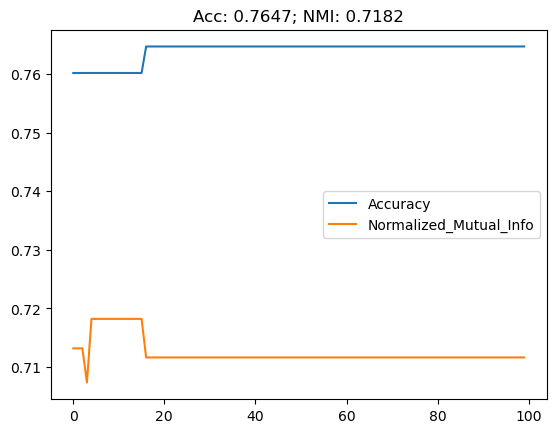

In [51]:
K_list = [K_dict[k] for k in K_dict.keys() if k.startswith("K_WL")]
kernel_name = [k for k in K_dict.keys() if k.startswith("K_WL")]
num_iter = 100

class_num = len(np.unique(y))
K_new, weights, score_dict = train(K_list, 'eigen', class_num, 1e-3, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter, class_num)

----- At No.1 iteration: sum: 1.0 norm: 0.449-----
eigengap ratio: [0.02264926]
acc_score: 0.7601809954751131; nmi: 0.7131804133720253

----- At No.11 iteration: sum: 1.0 norm: 0.5858-----
eigengap ratio: [0.0227744]
acc_score: 0.7601809954751131; nmi: 0.718210914252329

----- At No.21 iteration: sum: 1.0 norm: 0.6775-----
eigengap ratio: [0.0228099]
acc_score: 0.7647058823529411; nmi: 0.7116294273039254

----- At No.31 iteration: sum: 1.0 norm: 0.7502-----
eigengap ratio: [0.02282826]
acc_score: 0.7647058823529411; nmi: 0.7116294273039254

----- At No.41 iteration: sum: 1.0 norm: 0.7817-----
eigengap ratio: [0.02283313]
acc_score: 0.7647058823529411; nmi: 0.7116294273039254

----- At No.51 iteration: sum: 1.0 norm: 0.8205-----
eigengap ratio: [0.02283806]
acc_score: 0.7647058823529411; nmi: 0.7116294273039254

----- At No.61 iteration: sum: 1.0 norm: 0.8655-----
eigengap ratio: [0.02284306]
acc_score: 0.7647058823529411; nmi: 0.7116294273039254

----- At No.71 iteration: sum: 1.0 norm

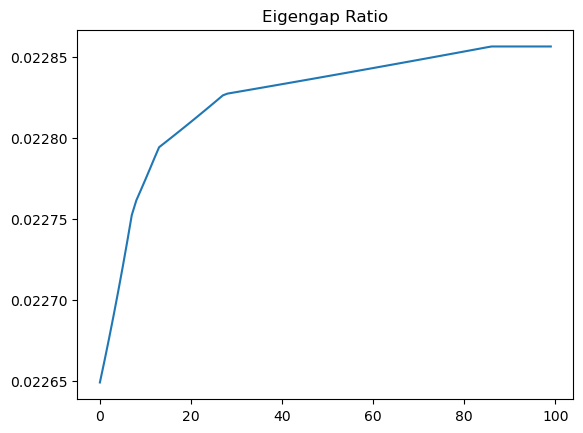

Final weights: [0. 0. 0. 0. 1.]
===== Individual acc_score | nmi=====
K_WL_1: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_2: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_3: 0.7602(acc); 0.7132(nmi) | weight: 0.0000
K_WL_4: 0.7602(acc); 0.7182(nmi) | weight: 0.0000
K_WL_5: 0.7647(acc); 0.7116(nmi) | weight: 1.0000
===== Joint kernel =====


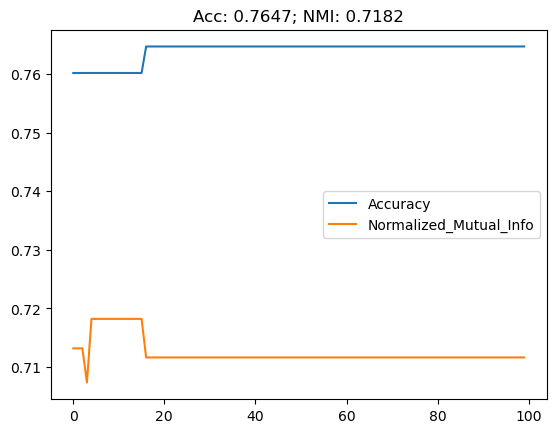

In [52]:
K_list = [K_dict[k] for k in K_dict.keys() if k.startswith("K_WL")]
kernel_name = [k for k in K_dict.keys() if k.startswith("K_WL")]
num_iter = 100

class_num = len(np.unique(y))
K_new, weights, score_dict = train(K_list, 'eigen_inv', class_num, 1e-3, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter, class_num)

# Subset kernels